In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn

In [2]:
# import warnings

# warnings.filterwarnings("ignore", category=FutureWarning, message=".*DataFrame.swapaxes.*")

# import pandas as pd
# import numpy as np
# from tqdm import tqdm
# import os
# path='/kaggle/input/nasa-battery-dataset'
# metadata = pd.read_csv(os.path.join(path, "cleaned_dataset", "metadata.csv"))
# metadata['battery_id'] = metadata['battery_id'].astype(str)


# excluded_batteries = ['B0049', 'B0050', 'B0051', 'B0052']

# discharge_metadata = metadata[
#     (metadata['type'] == 'discharge') &
#     (~metadata['battery_id'].isin(excluded_batteries))
# ].copy()

# discharge_metadata['cycle_number'] = discharge_metadata.groupby('battery_id').cumcount() + 1

# processed_dfs = []

# # Process each discharge cycle
# for _, row in tqdm(discharge_metadata.iterrows(), total=len(discharge_metadata)):
#     file_path = os.path.join(path, "cleaned_dataset", "data", row['filename'])
#     df = pd.read_csv(file_path).copy()

#     # Truncate data at the first point where voltage < 2.7V
#     cutoff_idx = df[df['Voltage_measured'] < 2.7].index.min()
#     truncated_df = df if pd.isna(cutoff_idx) else df.iloc[:cutoff_idx].copy()

#     # Compute capacity using coulomb counting (sum of current over time)
#     truncated_df['Time_diff_hr'] = truncated_df['Time'].diff().fillna(0) / 3600
#     truncated_df['Delta_Q'] = truncated_df['Current_measured'] * truncated_df['Time_diff_hr']
#     capacity = abs(truncated_df['Delta_Q'].sum())

#     # Only use cycles with capacity above threshold (filter out bad data)
#     if capacity > 1.4:
#         # Add battery and cycle info columns
#         truncated_df['battery_id'] = row['battery_id']
#         truncated_df['cycle_number'] = row['cycle_number']
#         # Calculate SoC using coulomb counting
#         truncated_df['Cumulative_Q'] = truncated_df['Delta_Q'].cumsum()
#         truncated_df['SoC'] = 100 * (1 + truncated_df['Cumulative_Q'] / capacity)
#         # Calculate SoH as percentage of nominal capacity (2.0 Ah)
#         soh_value = (capacity / 2.0) * 100
#         truncated_df['SoH'] = soh_value

#         # Downsample each cycle to 20 bins by averaging (for uniform length)
#         num_bins = 20
#         bins = np.array_split(truncated_df, num_bins)
#         agg_rows = []
#         for b in bins:
#             if b.empty:
#                 continue
#             avg_voltage = b['Voltage_measured'].mean()
#             avg_current = b['Current_measured'].mean()
#             avg_temp = b['Temperature_measured'].mean()
#             avg_soc = b['SoC'].mean()
#             agg_rows.append({
#                 'Voltage_measured': avg_voltage,
#                 'Current_measured': avg_current,
#                 'Temperature_measured': avg_temp,
#                 'SoC': avg_soc,
#                 'cycle_number': b['cycle_number'].iloc[0],
#                 'battery_id': b['battery_id'].iloc[0],
#                 'SoH': b['SoH'].iloc[0]
#             })
#         cycle_df = pd.DataFrame(agg_rows)
#         # Only accept cycles that yield exactly 20 bins
#         if len(cycle_df) != num_bins:
#             continue
#         processed_dfs.append(cycle_df)
# # Concatenate all cycles and save as new CSV
# if processed_dfs:
#     full_dataset = pd.concat(processed_dfs)
#     print(f"Final dataset shape: {full_dataset.shape}")
#     full_dataset.to_csv("battery_health_dataset.csv", index=False)


In [3]:

df_csv=pd.read_csv('/kaggle/input/final-dataset-csv/battery_health_dataset.csv')
df_csv = df_csv.drop(columns=['battery_id'], errors='ignore')
df = df_csv.groupby("cycle_number", as_index=False).mean()
temp=df['Temperature_measured' ]
current=df["Current_measured"]
voltage=df["Voltage_measured"]
soc=df["SoC"]
cycle_number=df["cycle_number"]
soh_true=df["SoH"]

In [4]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(5,16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,1)
        )
    def forward(self,voltage,soc,current,temp,cycles):
        x=torch.cat([voltage, soc, current, temp, cycles], dim=1)
        return self.net(x)

In [5]:
def physics_loss(model, cycle_number, voltage, soc, current, temp):
    # cycles plays the role of time
    cycle_number = cycle_number.clone().detach().requires_grad_(True)

    # forward pass
    soh = model(voltage, soc, current, temp, cycle_number)

    # derivative dSOH/dCycle
    dsoh_dcycle = torch.autograd.grad(
        soh, cycle_number,
        grad_outputs=torch.ones_like(soh),
        create_graph=True
    )[0]

    # SOH must decrease or stay constant
    loss_mono = torch.mean(torch.relu(dsoh_dcycle))

    # Arrhenius degradation law
    k = 1e-4
    alpha = 1.0
    R = 8.314
    Ea = 30000

    phys_res = dsoh_dcycle + k * torch.abs(current)**alpha * torch.exp(-Ea / (R * temp))
    loss_phys = torch.mean(phys_res ** 2)

    return loss_mono + loss_phys



In [6]:
def train_physics_informed(
    model,
    voltage, soc, current, temp, cycles,soh,
    epochs=5000,
    lr=1e-3,
    lambda_data=1.0,
    lambda_phys=1.0,
    verbose=True
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    for epoch in range(epochs):

        model.train()
        optimizer.zero_grad()

        # Predictions
        soh_pred = model(voltage, soc, current, temp, cycles)

        # Supervised loss
        loss_data = mse(soh_pred, soh)

        # Physics-informed loss
        loss_phys = physics_loss(model, cycles, voltage, soc, current, temp)

        # Total loss
        loss = lambda_data * loss_data + lambda_phys * loss_phys

        # Backprop
        loss.backward()
        optimizer.step()

        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch}/{epochs} | "
                  f"Total: {loss.item():.6f} | "
                  f"Data: {loss_data.item():.6f} | "
                  f"Phys: {loss_phys.item():.6f}")

    return model


In [7]:
def normalize(x):
    x_min = x.min()
    x_max = x.max()
    return (x - x_min) / (x_max - x_min), x_min, x_max

voltage, vmin, vmax = normalize(voltage)
soc, smin, smax = normalize(soc)
current, imin, imax = normalize(current)
temp, tmin, tmax = normalize(temp)
cycle_number, cmin, cmax = normalize(cycle_number)

In [8]:
voltage = torch.tensor(voltage.values, dtype=torch.float32).reshape(-1, 1)
soc = torch.tensor(soc.values, dtype=torch.float32).reshape(-1, 1)
current = torch.tensor(current.values, dtype=torch.float32).reshape(-1, 1)
temp = torch.tensor(temp.values, dtype=torch.float32).reshape(-1, 1)

cycle_number = torch.tensor(cycle_number.values, dtype=torch.float32).reshape(-1, 1)

soh_norm, soh_min, soh_max = normalize(df["SoH"])
soh_norm = torch.tensor(soh_norm.values, dtype=torch.float32).reshape(-1, 1)
soh_min = float(soh_min)
soh_max = float(soh_max)




In [9]:
def check_norm(name, tensor):
    print(f"{name}: min={tensor.min().item():.4f}, max={tensor.max().item():.4f}")

print("=== CHECK NORMALIZATION ===")
check_norm("voltage", voltage)
check_norm("current", current)
check_norm("temp", temp)
check_norm("soc", soc)
check_norm("cycles", cycle_number)
check_norm("soh_norm", soh_norm)


=== CHECK NORMALIZATION ===
voltage: min=0.0000, max=1.0000
current: min=0.0000, max=1.0000
temp: min=0.0000, max=1.0000
soc: min=0.0000, max=1.0000
cycles: min=0.0000, max=1.0000
soh_norm: min=0.0000, max=1.0000


In [10]:
model=PINN()
train_physics_informed(
    model,voltage, soc, current, temp, cycle_number,soh_norm,
)

Epoch 0/5000 | Total: 0.149115 | Data: 0.148922 | Phys: 0.000193
Epoch 500/5000 | Total: 0.007919 | Data: 0.007492 | Phys: 0.000427
Epoch 1000/5000 | Total: 0.003640 | Data: 0.003487 | Phys: 0.000153
Epoch 1500/5000 | Total: 0.003241 | Data: 0.003209 | Phys: 0.000032
Epoch 2000/5000 | Total: 0.002512 | Data: 0.002505 | Phys: 0.000007
Epoch 2500/5000 | Total: 0.002533 | Data: 0.002526 | Phys: 0.000006
Epoch 3000/5000 | Total: 0.002330 | Data: 0.002292 | Phys: 0.000038
Epoch 3500/5000 | Total: 0.002826 | Data: 0.002756 | Phys: 0.000070
Epoch 4000/5000 | Total: 0.002242 | Data: 0.002237 | Phys: 0.000004
Epoch 4500/5000 | Total: 0.002305 | Data: 0.002280 | Phys: 0.000025


PINN(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [11]:
with torch.no_grad():
    soh_pred_norm = model(voltage, soc, current, temp, cycle_number)
    soh_pred = soh_pred_norm * (soh_max - soh_min) + soh_min


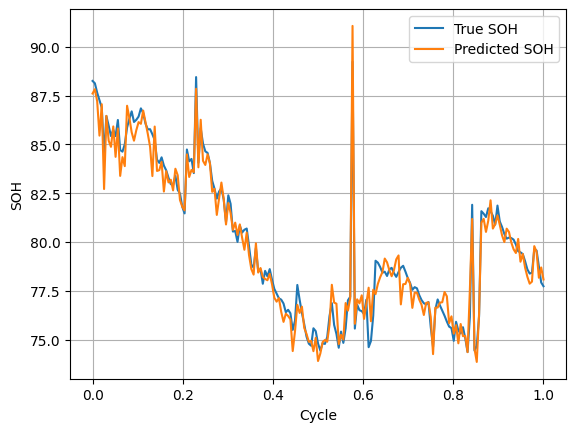

In [12]:
import matplotlib.pyplot as plt

plt.plot(cycle_number.numpy(), df["SoH"], label="True SOH")
plt.plot(cycle_number.numpy(), soh_pred.numpy(), label="Predicted SOH")
plt.legend()
plt.xlabel("Cycle")
plt.ylabel("SOH")
plt.grid()
plt.show()


In [13]:
torch.save(model.state_dict(), "model_weights.pth")
